In [1]:
# Import common libraries
import pandas as pd
from itertools import compress
from collections import defaultdict
from copy import deepcopy
from pprint import pprint
import os

# Import MNE processing
from mne.viz import plot_compare_evokeds
from mne import Epochs, events_from_annotations, set_log_level

# Import MNE-NIRS processing
import mne
from mne_nirs.channels import get_long_channels
from mne_nirs.channels import picks_pair_to_idx
from mne_nirs.datasets import fnirs_motor_group
from mne.preprocessing.nirs import beer_lambert_law, optical_density,\
    temporal_derivative_distribution_repair, scalp_coupling_index
from mne_nirs.signal_enhancement import enhance_negative_correlation

# Import MNE-BIDS processing
from mne_bids import BIDSPath, read_raw_bids

# Import StatsModels
import statsmodels.formula.api as smf

# Import Plotting Library
import matplotlib.pyplot as plt
import seaborn as sns

# Set general parameters
set_log_level("WARNING")  # Don't show info, as it is repetitive for many subjects


# Based on Guides Published Here
# https://mne.tools/mne-nirs/stable/auto_examples/general/plot_16_waveform_group.html

In [2]:
def individual_analysis(bids_path):

    # Read data with annotations in BIDS format
    # raw_intensity = read_raw_bids(bids_path=bids_path, verbose=False)
    raw_intensity = mne.io.read_raw_snirf(bids_path, verbose=True, preload=False)
    raw_intensity = get_long_channels(raw_intensity, min_dist=0.01)
    
    channel_types = raw_intensity
    print(channel_types)
    
    raw_intensity.annotations.rename({'4': 'Control', '2': 'Neutral', '3': 'Inflammatory', '1':'Practice'})

    # Convert signal to optical density and determine bad channels
    raw_od = optical_density(raw_intensity)
    sci = scalp_coupling_index(raw_od, h_freq=1.35, h_trans_bandwidth=0.1)
    raw_od.info["bads"] = list(compress(raw_od.ch_names, sci < 0.5))
    raw_od.interpolate_bads()

    # Downsample and apply signal cleaning techniques
    raw_od.resample(0.8)
    raw_od = temporal_derivative_distribution_repair(raw_od)

    # Convert to haemoglobin and filter
    raw_haemo = beer_lambert_law(raw_od, ppf=0.1)
    raw_haemo = raw_haemo.filter(0.02, 0.3,
                                 h_trans_bandwidth=0.1, l_trans_bandwidth=0.01,
                                 verbose=False)

    # Apply further data cleaning techniques and extract epochs
    raw_haemo = enhance_negative_correlation(raw_haemo)

    events, event_dict = events_from_annotations(raw_haemo, verbose=False)

    epochs = Epochs(raw_haemo, events, event_id=event_dict, tmin=-10, tmax= 40,
                    reject=dict(hbo=200e-6), reject_by_annotation=True,
                    proj=True, baseline=(None, 0), detrend=0,
                    preload=True, verbose=False)

    return raw_haemo, epochs

In [3]:
all_evokeds = defaultdict(list)

subjects = os.listdir("../BIDS_Direct/")
for sub in subjects:
    if sub != ".DS_Store":
        # Create path to file based on experiment info
        f_path = f'../BIDS_Direct/{sub}/nirs/{sub}_task-AnonCom_nirs.snirf'
        
        # Analyse data and return both ROI and channel results
        raw_haemo, epochs = individual_analysis(f_path)
        
        # Save individual-evoked participant data along with others in all_evokeds
        for cidx, condition in enumerate(epochs.event_id):
            # print(epochs)
            all_evokeds[condition].append(epochs[condition].average())
            
# pprint(all_evokeds)

Loading /Users/nolanbrady/Desktop/LabResearch/IndependentStudy/DataAnalysis/FADataAnalysisScripts/../BIDS_Direct/sub-01/nirs/sub-01_task-AnonCom_nirs.snirf
<RawSNIRF | sub-01_task-AnonCom_nirs.snirf, 36 x 17098 (1680.6 s), ~4.9 MB, data loaded>
Loading /Users/nolanbrady/Desktop/LabResearch/IndependentStudy/DataAnalysis/FADataAnalysisScripts/../BIDS_Direct/sub-02/nirs/sub-02_task-AnonCom_nirs.snirf


/var/folders/f_/0f3gmdgs0db0f5gf8gg2874c0000gn/T/ipykernel_6478/2133783309.py:17: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  raw_od.interpolate_bads()


<RawSNIRF | sub-02_task-AnonCom_nirs.snirf, 36 x 14804 (1455.1 s), ~4.2 MB, data loaded>
Loading /Users/nolanbrady/Desktop/LabResearch/IndependentStudy/DataAnalysis/FADataAnalysisScripts/../BIDS_Direct/sub-04/nirs/sub-04_task-AnonCom_nirs.snirf


/var/folders/f_/0f3gmdgs0db0f5gf8gg2874c0000gn/T/ipykernel_6478/2133783309.py:17: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  raw_od.interpolate_bads()


<RawSNIRF | sub-04_task-AnonCom_nirs.snirf, 36 x 16843 (1655.6 s), ~4.8 MB, data loaded>


/var/folders/f_/0f3gmdgs0db0f5gf8gg2874c0000gn/T/ipykernel_6478/2133783309.py:17: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  raw_od.interpolate_bads()


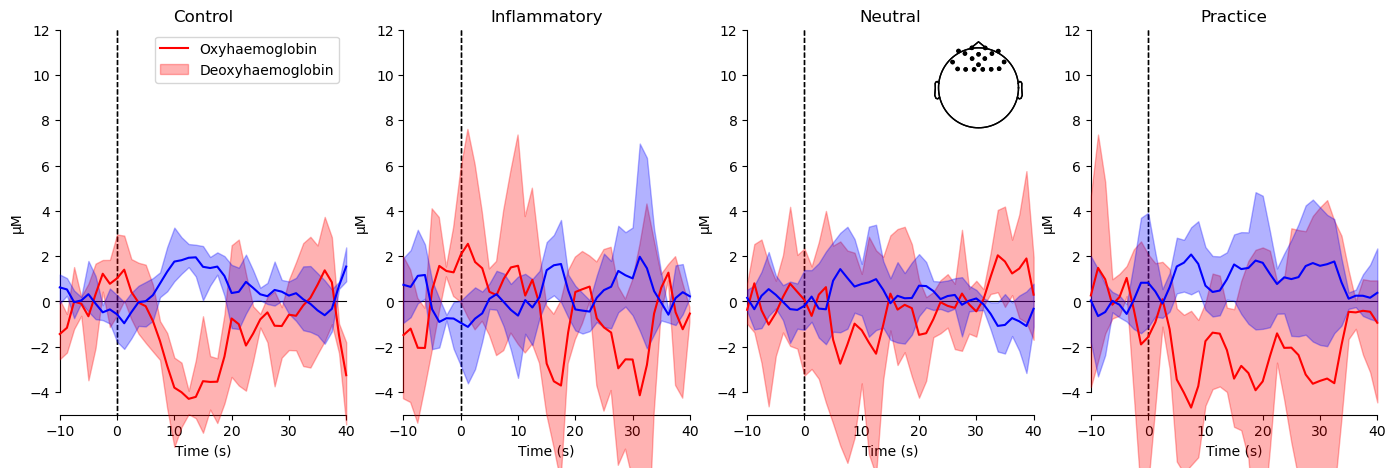

In [4]:
# Print figures

# Specify the figure size and limits per chromophore
fig, axes = plt.subplots(nrows=1, ncols=len(all_evokeds), figsize=(17, 5))
lims = dict(hbo=[-5, 12], hbr=[-5, 12])

for (pick, color) in zip(['hbo', 'hbr'], ['r', 'b']):
    for idx, evoked in enumerate(all_evokeds):
        plot_compare_evokeds({evoked: all_evokeds[evoked]}, combine='mean',
                             picks=pick, axes=axes[idx], show=False,
                             colors=[color], legend=False, ylim=lims, ci=0.95,
                             show_sensors=idx == 2)
        axes[idx].set_title('{}'.format(evoked))
axes[0].legend(["Oxyhaemoglobin", "Deoxyhaemoglobin"])

In [5]:
# Extract Evoked Amplitude

df = pd.DataFrame(columns=['ID', 'Chroma', 'Condition', 'Value'])

for idx, evoked in enumerate(all_evokeds):
    subj_id = 0
    for subj_data in all_evokeds[evoked]:
        subj_id += 1
        for chroma in ["hbo", "hbr"]:
            data = deepcopy(subj_data)
            value = data.crop(tmin=5.0, tmax=40.0).data.mean() * 1.0e6

            # Append metadata and extracted feature to dataframe
            this_df = pd.DataFrame(
                {'ID': subj_id, 'Chroma': chroma,
                 'Condition': evoked, 'Value': value}, index=[0])
            df = pd.concat([df, this_df], ignore_index=True)
df.reset_index(inplace=True, drop=True)
df['Value'] = pd.to_numeric(df['Value'])  # some Pandas have this as object

# You can export the dataframe for analysis in your favorite stats program
df.to_csv("stats-export.csv")

# Print out the first entries in the dataframe
# df

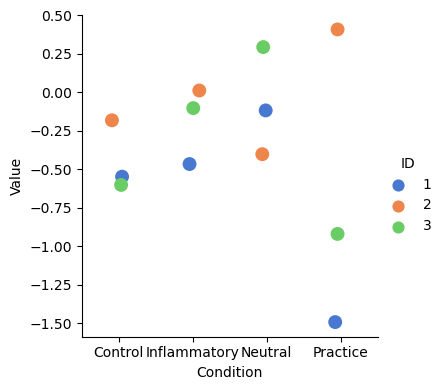

In [6]:
# Plot the Data
sns.catplot(x="Condition", y="Value", hue="ID", data=df.query("Chroma == 'hbo'"), ci=None, palette="muted", height=4, s=10)


In [7]:
# Inflammatory vs Neutral Prompt Analysis

input_data = df.query("Condition in ['Neutral', 'Inflammatory']")
input_data = input_data.query("Chroma in ['hbo']")

model = smf.mixedlm("Value ~ Condition", input_data, groups=input_data["ID"]).fit()
model.summary()

/Users/nolanbrady/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/Users/nolanbrady/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


<class 'statsmodels.iolib.summary2.Summary'>
"""
             Mixed Linear Model Regression Results
===============================================================
Model:                MixedLM    Dependent Variable:    Value  
No. Observations:     6          Method:                REML   
No. Groups:           3          Scale:                 0.0924 
Min. group size:      2          Log-Likelihood:        -2.0115
Max. group size:      2          Converged:             Yes    
Mean group size:      2.0                                      
---------------------------------------------------------------
                     Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------
Intercept            -0.185    0.176 -1.055 0.291 -0.529  0.159
Condition[T.Neutral]  0.110    0.248  0.445 0.657 -0.376  0.597
Group Var             0.000    0.249                           
===============================================================

"""

In [8]:
# Control vs Neutral Prompt Analysis

input_data = df.query("Condition in ['Control', 'Neutral']")
input_data = input_data.query("Chroma in ['hbo']")

model = smf.mixedlm("Value ~ Condition", input_data, groups=input_data["ID"]).fit()
model.summary()

/Users/nolanbrady/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/nolanbrady/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/Users/nolanbrady/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/Users/nolanbrady/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


<class 'statsmodels.iolib.summary2.Summary'>
"""
             Mixed Linear Model Regression Results
===============================================================
Model:                MixedLM    Dependent Variable:    Value  
No. Observations:     6          Method:                REML   
No. Groups:           3          Scale:                 0.0874 
Min. group size:      2          Log-Likelihood:        -1.9013
Max. group size:      2          Converged:             Yes    
Mean group size:      2.0                                      
---------------------------------------------------------------
                     Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------
Intercept            -0.444    0.171 -2.598 0.009 -0.778 -0.109
Condition[T.Neutral]  0.369    0.241  1.528 0.127 -0.104  0.842
Group Var             0.000                                    
===============================================================

"""

In [9]:
# Control vs Inflammatory Prompt Analysis

input_data = df.query("Condition in ['Control', 'Inflammatory']")
input_data = input_data.query("Chroma in ['hbo']")

model = smf.mixedlm("Value ~ Condition", input_data, groups=input_data["ID"]).fit()
model.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
               Mixed Linear Model Regression Results
====================================================================
Model:                 MixedLM      Dependent Variable:      Value  
No. Observations:      6            Method:                  REML   
No. Groups:            3            Scale:                   0.0233 
Min. group size:       2            Log-Likelihood:          -0.6218
Max. group size:       2            Converged:               Yes    
Mean group size:       2.0                                          
--------------------------------------------------------------------
                          Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------------------
Intercept                 -0.444    0.138 -3.210 0.001 -0.714 -0.173
Condition[T.Inflammatory]  0.258    0.125  2.073 0.038  0.014  0.503
Group Var                  0.034    0.422                           
====================================================================

"""